# [How to do Transfer learning with Efficientnet](https://www.dlology.com/blog/transfer-learning-with-efficientnet/) 

## Imports

In [1]:
# Downgrade pillow to avoid `UserWarning: Possibly corrupt EXIF data.`
!pip install pillow==4.0.0

In [0]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

## Hyper parameters

In [0]:
batch_size = 48

width = 150
height = 150
epochs = 20
NUM_TRAIN = 2000
NUM_TEST = 1000
dropout_rate = 0.2
input_shape = (height, width, 3)

## Clone **efficientnet** repo

In [4]:
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
    !git clone https://github.com/Tony607/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/content
/content/efficientnet_keras_transfer_learning


## Import efficientnet and load the conv base model

In [0]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB3 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [12]:
# loading pretrained conv base model
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

W0623 06:12:44.382034 139823591925632 deprecation_wrapper.py:119] From /content/efficientnet_keras_transfer_learning/efficientnet/model.py:67: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0623 06:12:44.504250 139823591925632 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0623 06:12:44.835230 139823591925632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/converters/directives.py:117: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0623 06:12:44.951386 139823591925632 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/im

43974656/43966704 [==============================] - 0s 0us/step


## Download and extract `dog_vs_cat` dataset

In [13]:
if not os.path.isfile("kagglecatsanddogs_3367a.zip"):
    !wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
    !unzip -qq kagglecatsanddogs_3367a.zip -d dog_vs_cat
else:
    print("dataset already exist.")

dataset already exist.


In [14]:
!ls dog_vs_cat/PetImages/
!ls dog_vs_cat/PetImages/Cat -l -t | head -10

Cat  Dog
total 408428
-rw-r--r-- 1 root root   34297 Feb 10  2017 9955.jpg
-rw-r--r-- 1 root root   26013 Feb 10  2017 9956.jpg
-rw-r--r-- 1 root root   26293 Feb 10  2017 9957.jpg
-rw-r--r-- 1 root root   36293 Feb 10  2017 9958.jpg
-rw-r--r-- 1 root root   36690 Feb 10  2017 9959.jpg
-rw-r--r-- 1 root root   15262 Feb 10  2017 9960.jpg
-rw-r--r-- 1 root root   49493 Feb 10  2017 9961.jpg
-rw-r--r-- 1 root root   14785 Feb 10  2017 9962.jpg
-rw-r--r-- 1 root root   39717 Feb 10  2017 9963.jpg


In [15]:
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = './dog_vs_cat/PetImages'

cat_images = glob.glob(os.path.join(original_dataset_dir, "Cat", '*.jpg'))
dog_images = glob.glob(os.path.join(original_dataset_dir, "Dog", '*.jpg'))
print("total cat images: {}\n\rtotal dog images: {}".format(len(cat_images), len(dog_images)))

total cat images: 12500
total dog images: 12500


In [0]:
# The directory where we will
# store our smaller dataset
base_dir = './data/dog_vs_cat_small'
os.makedirs(base_dir, exist_ok=True)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
os.makedirs(train_cats_dir, exist_ok=True)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.makedirs(train_dogs_dir, exist_ok=True)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.makedirs(validation_cats_dir, exist_ok=True)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.makedirs(validation_dogs_dir, exist_ok=True)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
os.makedirs(test_cats_dir, exist_ok=True)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.makedirs(test_dogs_dir, exist_ok=True)

# Copy first NUM_TRAIN//2 cat images to train_cats_dir
fnames = cat_images[:NUM_TRAIN//2]
for fname in fnames:
    dst = os.path.join(train_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

offset = NUM_TRAIN//2
# Copy next NUM_TEST //2 cat images to validation_cats_dir
fnames = cat_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(validation_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
offset = offset + NUM_TEST // 2
# Copy next NUM_TRAIN//2 cat images to test_cats_dir
fnames = cat_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(test_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


# Copy first NUM_TRAIN//2 dog images to train_dogs_dir
fnames = dog_images[:NUM_TRAIN//2]
for fname in fnames:
    dst = os.path.join(train_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

offset = NUM_TRAIN//2
# Copy next NUM_TEST // 2 dog images to validation_dogs_dir
fnames = dog_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(validation_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
offset = offset + NUM_TEST // 2

# Copy next NUM_TEST // 2 dog images to test_dogs_dir
fnames = dog_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(test_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

In [17]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to target height and width.
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(2, activation='softmax', name="fc_out"))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Model)      (None, 5, 5, 1536)        10783528  
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1536)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1536)              0         
_________________________________________________________________
fc_out (Dense)               (None, 2)                 3074      
Total params: 10,786,602
Trainable params: 10,699,306
Non-trainable params: 87,296
_________________________________________________________________


In [21]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 340
This is the number of trainable layers after freezing the conv base: 2


In [22]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

Epoch 1/20
41/41 [==============================] - 23s 553ms/step - loss: 1.7546 - acc: 0.4928 - val_loss: 2.1525 - val_acc: 0.5583
Epoch 2/20
41/41 [==============================] - 18s 432ms/step - loss: 1.6382 - acc: 0.5010 - val_loss: 2.1048 - val_acc: 0.5656
Epoch 3/20
41/41 [==============================] - 18s 438ms/step - loss: 1.5613 - acc: 0.5274 - val_loss: 2.1025 - val_acc: 0.5771
Epoch 4/20
41/41 [==============================] - 18s 435ms/step - loss: 1.4959 - acc: 0.5150 - val_loss: 1.9425 - val_acc: 0.5854
Epoch 5/20
41/41 [==============================] - 18s 438ms/step - loss: 1.5377 - acc: 0.5343 - val_loss: 1.8641 - val_acc: 0.5917
Epoch 6/20
41/41 [==============================] - 18s 438ms/step - loss: 1.4801 - acc: 0.5297 - val_loss: 1.7975 - val_acc: 0.5917
Epoch 7/20
41/41 [==============================] - 18s 441ms/step - loss: 1.5148 - acc: 0.5272 - val_loss: 1.6879 - val_acc: 0.6062
Epoch 8/20
41/41 [==============================] - 18s 448ms/step - 

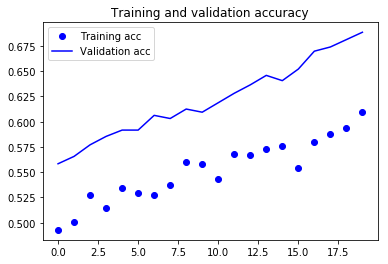

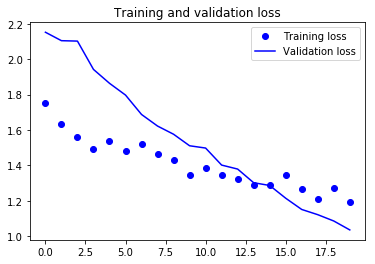

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Fine tuning last several layers.

In [0]:
# multiply_16
# set 'multiply_16' and following layers trainable
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'multiply_16':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [25]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

Epoch 1/20
41/41 [==============================] - 33s 816ms/step - loss: 1.1021 - acc: 0.6199 - val_loss: 0.6904 - val_acc: 0.7677
Epoch 2/20
41/41 [==============================] - 20s 481ms/step - loss: 0.9173 - acc: 0.6691 - val_loss: 0.5476 - val_acc: 0.7969
Epoch 3/20
41/41 [==============================] - 20s 479ms/step - loss: 0.8405 - acc: 0.6972 - val_loss: 0.5263 - val_acc: 0.8146
Epoch 4/20
41/41 [==============================] - 20s 480ms/step - loss: 0.7184 - acc: 0.7428 - val_loss: 0.5157 - val_acc: 0.8219
Epoch 5/20
41/41 [==============================] - 20s 483ms/step - loss: 0.6562 - acc: 0.7515 - val_loss: 0.5328 - val_acc: 0.8198
Epoch 6/20
41/41 [==============================] - 20s 499ms/step - loss: 0.6023 - acc: 0.7833 - val_loss: 0.5189 - val_acc: 0.8292
Epoch 7/20
41/41 [==============================] - 20s 492ms/step - loss: 0.5056 - acc: 0.7987 - val_loss: 0.5045 - val_acc: 0.8354
Epoch 8/20
41/41 [==============================] - 20s 486ms/step - 

In [0]:
os.makedirs("./models", exist_ok=True)
model.save('./models/cats_and_dogs_small.h5')

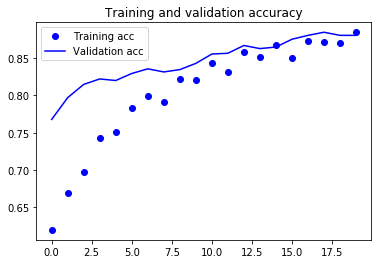

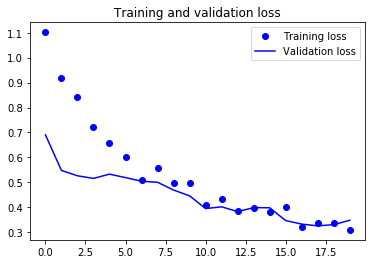

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Test predict

In [0]:
cat_img = cat_images[-1]
dog_img= dog_images[-1]

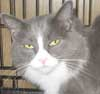

In [29]:
Image(filename=cat_img)

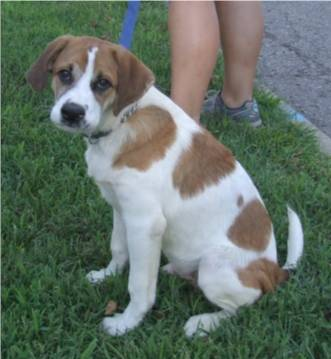

In [30]:
Image(filename=dog_img)

In [31]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])[0][0]
    if result > 0.5:
        animal = "cat"
    else:
        animal = "dog"
        result = 1 - result
    return animal,result

print(predict_image(cat_img))
print(predict_image(dog_img))

('cat', 0.99995065)
('dog', 0.9849699269980192)


## Download the model

In [0]:
from google.colab import files

files.download('./models/cats_and_dogs_small.h5')

In [33]:
model.input_shape

(None, 150, 150, 3)

## Load the model

In [0]:
from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [0]:
from tensorflow.keras.models import load_model
model = load_model("./models/cats_and_dogs_small.h5")